The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Batch Normalization

:label:`sec_batch_norm`


Training deep neural nets is difficult.
And getting them to converge in a reasonable amount of time can be tricky.  
In this section, we describe batch normalization (BN)
:cite:`Ioffe.Szegedy.2015`, a popular and effective technique 
that consistently accelerates the convergence of deep nets. 
Together with residual blocks—covered in :numref:`sec_resnet`—BN
has made it possible for practitioners 
to routinely train networks with over 100 layers.



## Training Deep Networks

To motivate batch normalization, let's review 
a few practical challenges that arise 
when training ML models and neural nets in particular.

1. Choices regarding data preprocessing often 
   make an enormous difference in the final results.
   Recall our application of multilayer perceptrons 
   to predicting house prices (:numref:`sec_kaggle_house`).
   Our first step when working with real data 
   was to standardize our input features 
   to each have a mean of *zero* and variance of *one*. 
   Intuitively, this standardization plays nicely with our optimizers
   because it puts the  parameters are a-priori at a similar scale.
1. For a typical MLP or CNN, as we train, 
   the activations in intermediate layers 
   may take values with widely varying magnitudes—both 
   along the layers from the input to the output,
   across nodes in the same layer, 
   and over time due to our updates to the model's parameters. 
   The inventors of batch normalization postulated informally
   that this drift in the distribution of activations 
   could hamper the convergence of the network. 
   Intuitively, we might conjecture that if one
   layer has activation values that are 100x that of another layer, 
   this might necessitate compensatory adjustments in the learning rates.
1. Deeper networks are complex and easily capable of overfitting. 
   This means that regularization becomes more critical. 
   
Batch normalization is applied to individual layers
(optionally, to all of them) and works as follows:
In each training iteration,
for each layer, we first compute its activations as usual.
Then, we normalize the activations of each node 
by subtracting its mean and dividing by its standard deviation 
estimating both quantities based on the statistics of the current the current minibatch.  
It is precisely due to this *normalization* based on *batch* statistics 
that *batch normalization* derives its name.

Note that if we tried to apply BN with minibatches of size $1$, 
we would not be able to learn anything.
That is because after subtracting the means,
each hidden node would take value $0$!
As you might guess, since we are devoting a whole section to BN, 
with large enough minibatches, the approach proves effective and stable.
One takeaway here is that when applying BN, 
the choice of minibatch size may be 
even more significant than without BN. 

Formally, BN transforms the activations at a given layer $\mathbf{x}$ 
according to the following expression:

$$\mathrm{BN}(\mathbf{x}) = \mathbf{\gamma} \odot \frac{\mathbf{x} - \hat{\mathbf{\mu}}}{\hat\sigma} + \mathbf{\beta}$$

Here, $\hat{\mathbf{\mu}}$ is the minibatch sample mean 
and $\hat{\mathbf{\sigma}}$ is the minibatch sample variance.
After applying BN, the resulting minibatch of activations 
has zero mean and unit variance.
Because the choice of unit variance 
(vs some other magic number) is an arbitrary choice, 
we commonly include coordinate-wise 
scaling coefficients $\mathbf{\gamma}$ and offsets $\mathbf{\beta}$.
Consequently, the activation magnitudes 
for intermediate layers cannot diverge during training
because BN actively centers and rescales them back 
to a given mean and size (via $\mathbf{\mu}$ and $\sigma$).
One piece of practitioner's intuition/wisdom 
is that BN seems to allows for more aggressive learning rates.


Formally, denoting a particular minibatch by $\mathcal{B}$, 
we calculate $\hat{\mathbf{\mu}}_\mathcal{B}$ and $\hat\sigma_\mathcal{B}$ as follows:

$$\hat{\mathbf{\mu}}_\mathcal{B} \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\text{ and }
\hat{\mathbf{\sigma}}_\mathcal{B}^2 \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \mathbf{\mu}_{\mathcal{B}})^2 + \epsilon$$

Note that we add a small constant $\epsilon > 0$ 
to the variance estimate
to ensure that we never attempt division by zero,
even in cases where the empirical variance estimate might vanish.
The estimates $\hat{\mathbf{\mu}}_\mathcal{B}$
and $\hat{\mathbf{\sigma}}_\mathcal{B}$ counteract the scaling issue
by using noisy estimates of mean and variance.
You might think that this noisiness should be a problem.
As it turns out, this is actually beneficial.

This turns out to be a recurring theme in deep learning. 
For reasons that are not yet well-characterized theoretically,
various sources of noise in optimization 
often lead to faster training and less overfitting. 
While traditional machine learning theorists 
might buckle at this characterization,
this variation appears to act as a form of regularization.
In some preliminary research, 
:cite:`Teye.Azizpour.Smith.2018` and :cite:`Luo.Wang.Shao.ea.2018` 
relate the properties of BN to Bayesian Priors and penalties respectively.
In particular, this sheds some light on the puzzle 
of why BN works best for moderate minibatches sizes in the $50$–$100$ range.

Fixing a trained model, you might (rightly) think 
that we would prefer to use the entire dataset 
to estimate the mean and variance.
Once training is complete, why would we want 
the same image to be classified differently,
depending on the batch in which it happens to reside?
During training, such exact calculation is infeasible
because the activations for all data points
change every time we update our model.
However, once the model is trained, 
we can calculate the means and variances 
of each layer's activations based on the entire dataset. 
Indeed this is standard practice for 
models employing batch normalization
and thus MXNet's BN layers function differently
in *training mode* (normalizing by minibatch statistics)
and in *prediction mode* (normalizing by dataset statistics).

We are now ready to take a look at how batch normalization works in practice.


## Batch Normalization Layers

Batch normalization implementations for fully-connected layers
and convolutional layers are slightly different.
We discuss both cases below.
Recall that one key differences between BN and other layers
is that because BN operates on a full minibatch at a time,
we cannot just ignore the batch dimension 
as we did before when introducing other layers.


### Fully-Connected Layers

When applying BN to fully-connected layers,
we usually insert BN after the affine transformation
and before the nonlinear activation function.
Denoting the input to the layer by $\mathbf{x}$,
the linear transform (with weights $\theta$) by $f_{\theta}(\cdot)$,
the activation function by $\phi(\cdot)$,
and the BN operation with parameters $\mathbf{\beta}$ and $\mathbf{\gamma}$ 
by $\mathrm{BN}_{\mathbf{\beta}, \mathbf{\gamma}}$, 
we can express the computation of a BN-enabled, 
fully-connected layer $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\mathrm{BN}_{\mathbf{\beta}, \mathbf{\gamma}}(f_{\mathbf{\theta}}(\mathbf{x}) ) ) $$

Recall that mean and variance are computed
on the *same* minibatch $\mathcal{B}$
on which the transformation is applied.
Also recall that the scaling coefficient $\mathbf{\gamma}$
and the offset $\mathbf{\beta}$ are parameters that need to be learned
jointly with the more familiar parameters $\mathbf{\theta}$.

### Convolutional Layers

Similarly, with convolutional layers, 
we typically apply BN after the convolution
and before the nonlinear activation function.
When the convolution has multiple output channels,
we need to carry out batch normalization
for *each* of the outputs of these channels,
and each channel has its own scale and shift parameters, 
both of which are scalars.
Assume that our minibatches contain $m$ each
and that for each channel, 
the output of the convolution has height $p$ and width $q$.
For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.
Thus we collect the values over all spatial locations 
when computing the mean and variance
and consequently (within a given channel) 
apply the same $\hat{\mathbf{\mu}}$ and $\hat{\mathbf{\sigma}}$
to normalize the values at each spatial location.


### Batch Normalization During Prediction

As we mentioned earlier, BN typically behaves differently
in training mode and prediction mode. 
First, the noise in $\mathbf{\mu}$ and $\mathbf{\sigma}$
arising from estimating each on minibatches
are no longer desirable once we have trained the model.
Second, we might not have the luxury
of computing per-batch normalization statistics, e.g.,
we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset 
to compute stable estimates of the activation statistics
and then fix them at prediction time.
Consequently, BN behaves differently during training and at test time.
Recall that dropout also exhibits this characteristic.

## Implementation from Scratch

Below, we implement a batch normalization layer with `ndarray`s from scratch:

In [1]:
import d2l
from mxnet import autograd, np, npx, init
from mxnet.gluon import nn
npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use autograd to determine whether the current mode is training mode or
    # prediction mode
    if not autograd.is_training():
        # If it is the prediction mode, directly use the mean and variance
        # obtained from the incoming moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcast operation
            # can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance of the moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

We can now create a proper `BatchNorm` layer.
Our layer will maintain poper parameters 
corresponding for scale `gamma` and shift `beta`,
both of which will be updated in the course of training.
Additionally, our layer will maintain 
a moving average of the means and variances
for subsequent use during model prediction.
The `num_features` parameter required by the `BatchNorm` instance
is the number of outputs for a fully-connected layer
and the number of output channels for a convolutional layer.
The `num_dims` parameter also required by this instance
is 2 for a fully-connected layer and 4 for a convolutional layer.

Putting aside the algorithmic details, 
note the design pattern underlying our implementation of the layer.
Typically, we define the math in a separate function, say `batch_norm`.
We then integrate this functionality into a custom layer,
whose code mostly addresses bookkeeping matters,
such as moving data to the right device context,
allocating and initializing any required variables,
keeping track of running averages (here for mean and variance), etc.
This pattern enables a clean separation of math from boilerplate code.
Also note that for the sake of convenience
we did not worry about automatically inferring the input shape here,
thus our need to specify the number of features throughout.
Do not worry, the Gluon `BatchNorm` layer will care of this for us.

In [2]:
class BatchNorm(nn.Block):
    def __init__(self, num_features, num_dims, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter involved in gradient
        # finding and iteration are initialized to 0 and 1 respectively
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # All the variables not involved in gradient finding and iteration are
        # initialized to 0 on the CPU
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.zeros(shape)

    def forward(self, X):
        # If X is not on the CPU, copy moving_mean and moving_var to the
        # device where X is located
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

## Using a Batch Normalization LeNet

To see how to apply `BatchNorm` in context, 
below we apply it to a traditional LeNet model (:numref:`sec_lenet`).
Recall that BN is typically applied 
after the convolutional layers and fully-connected layers
but before the corresponding activation functions.

In [3]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))

As before, we will train our network on the Fashion-MNIST dataset.
This code is virtually identical to that when we first trained LeNet (:numref:`sec_lenet`).
The main difference is the considerably larger learning rate.

loss 0.242, train acc 0.912, test acc 0.878
21664.5 examples/sec on gpu(0)


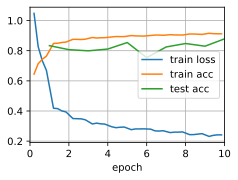

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

Let's have a look at the scale parameter `gamma`
and the shift parameter `beta` learned
from the first batch normalization layer.

In [5]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([1.9966985, 1.247909 , 2.7946453, 1.6399548, 2.1797724, 1.5462276], ctx=gpu(0)),
 array([ 1.440378  ,  0.01310529, -3.1554403 , -0.22097225, -0.05751804,
        -0.44032487], ctx=gpu(0)))

## Concise Implementation

Compared with the `BatchNorm` class, 
which we just defined ourselves,
the `BatchNorm` class defined by the `nn` model in Gluon is easier to use.
In Gluon, we do not have to worry about `num_features` or `num_dims`.
Instead, these parameter values will be 
inferred automatically via delayed initialization.
Otherwise, the code looks virtually identical
to the application our implementation above.

In [6]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

Below, we use the same hyper-parameters to train out model.
Note that as usual, the Gluon variant runs much faster
because its code has been compiled to C++/CUDA
while our custom implementation must be interpreted by Python.

loss 0.251, train acc 0.908, test acc 0.849
40502.5 examples/sec on gpu(0)


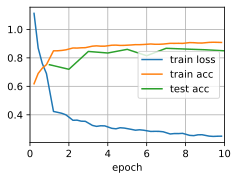

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Controversy

Intuitively, batch normalization is thought 
to make the optimization landscape smoother.
However, we must be careful to distinguish between
speculative intuitions and true explanations
for the phenomena that we observe when training deep models.
Recall that we do not even know why simpler
deep neural networks (MLPs and conventional CNNs) 
generalize well in the first place.
Even with dropout and L2 regularization,
they remain so flexible that their ability to generalize to unseen data
cannot be explained via conventional learning-theoretic generalization guarantees.

In the original paper proposing batch normalization,
the authors, in addition to introducing a powerful and useful tool,
offered an explanation for why it works:
by reducing *internal covariate shift*.
Presumably by *internal covariate shift* the authors
meant something like the intuition expressed above—the
notion that the distribution of activations changes
over the course of training.
However there were two problems with this explanation:
(1) This drift is very different from *covariate shift*,
rendering the name a misnomer.
(2) The explanation offers an under-specified intuition 
but leaves the question of *why precisely this technique works* 
an open question wanting for a rigorous explanation.
Throughout this book, we aim to convey the intuitions that practitioners
use to guide their development of deep neural networks.
However, we believe that it is important 
to separate these guiding intuitions
from established scientific fact.
Eventually, when you master this material
and start writing your own research papers
you will want to be clear to delineate
between technical claims and hunches.

Following the success of batch normalization, 
its explanation in terms of *internal covariate shift* 
has repeatedly surfaced in debates in the technical literature
and broader discourse about how to present machine learning research. 
In a memorable speech given while accepting a Test of Time Award 
at the 2017 NeurIPS conference, 
Ali Rahimi used *internal covariate shift* 
as a focal point in an argument likening 
the modern practice of deep learning to alchemy.
Subsequently, the example was revisited in detail
in a position paper outlining 
troubling trends in machine learning :cite:`Lipton.Steinhardt.2018`.  
In the technical literature other authors (:cite:`Santurkar.Tsipras.Ilyas.ea.2018`) 
have proposed alternative explanations for the success of BN, 
some claiming that BN's success comes despite exhibiting behavior 
that is in some ways opposite to those claimed in the original paper.

We note that the *internal covariate shift* 
is no more worthy of criticism than any of 
thousands of similarly vague claims 
made every year in the technical ML literature. 
Likely, its resonance as a focal point of these debates
owes to its broad recognizability to the target audience.
Batch normalization has proven an indispensable method,
applied in nearly all deployed image classifiers, 
earning the paper that introduced the technique
tens of thousands of citations.


## Summary

* During model training, batch normalization continuously adjusts the intermediate output of the neural network by utilizing the mean and standard deviation of the minibatch, so that the values of the intermediate output in each layer throughout the neural network are more stable.
* The batch normalization methods for fully connected layers and convolutional layers are slightly different.
* Like a dropout layer, batch normalization layers have different computation results in training mode and prediction mode.
* Batch Normalization has many beneficial side effects, primarily that of regularization. On the other hand, the original motivation of reducing covariate shift seems not to be a valid explanation.

## Exercises

1. Can we remove the fully connected affine transformation before the batch normalization or the bias parameter in convolution computation?
    * Find an equivalent transformation that applies prior to the fully connected layer.
    * Is this reformulation effective. Why (not)?
1. Compare the learning rates for LeNet with and without batch normalization.
    * Plot the decrease in training and test error.
    * What about the region of convergence? How large can you make the learning rate?
1. Do we need Batch Normalization in every layer? Experiment with it?
1. Can you replace Dropout by Batch Normalization? How does the behavior change?
1. Fix the coefficients `beta` and `gamma` (add the parameter `grad_req='null'` at the time of construction to avoid calculating the gradient), and observe and analyze the results.
1. Review the Gluon documentation for `BatchNorm` to see the other applications for Batch Normalization.
1. Research ideas: think of other normalization transforms that you can apply? Can you apply the probability integral transform? How about a full rank covariance estimate?

## [Discussions](https://discuss.mxnet.io/t/2358)

![](../img/qr_batch-norm.svg)